This notebook uses matrix-based entropy [1, 2, 3] to analyze the "mutual information plane" of pretrained LLMs. 

Great matrix entropy theorethical formulation provided by Oscar Skean!

## The Matrix-based Entropy Quantity


Matrix-based entropy was first proposed in [1]. It is a quantity which serves as a tractable surrogate for traditional Shannon's entropy. It's calculated using a kernel $\kappa$ on a batch of samples drawn from a distribution, without making explicit assumptions on what the true distribution is. Before introducing matrix-based entropy, it would be helpful to introduce its traditional information theory analogue called Renyi entropy, given by:

\begin{equation}
\tag{Renyi Entropy}
H_{\alpha}({P}) = \frac{1}{1-\alpha}\log{\sum_{i-1}^n p_i^{\alpha}}
\end{equation}

The Renyi entropy is a family of entropies parameterized by $\alpha$. Notable special cases are $\alpha=0$ (max-entropy), $\displaystyle \lim_{\alpha \rightarrow 1}$ (Shannon entropy), and $\alpha=2$ (collision entropy). A good writeup of Renyi entropy and the usecases of different choices of $\alpha$ is given in [4].

The definition of matrix-based entropy is given as follows.
Given a infinitely divisible kernel $\kappa$, we first construct a Gram matrix $\mathbf{K}_{\mathbf{X}} \in \mathbb{R}^{\textrm{N} \times \textrm{N}}$ consisting of all pairwise evaluations of the $N$ points in $\mathbf{X}$. The choice of $\kappa$ can be fairly flexible and could be a Gaussian kernel, linear kernel, Laplacian kernel, etc. Given $\mathbf{K}_{\mathbf{X}}$, the matrix-based entropy of order $\alpha>0$ is defined as:
\begin{equation}
\tag{Matrix-based Entropy}
S_{\alpha}\left(\mathbf{K}_{\mathbf{X}}\right) = \frac{1}{1-\alpha}\log{\left[\textrm{tr}{\left( \left( \frac{\mathbf{K}_{\mathbf{X}}}{\textrm{tr}(\mathbf{K}_{\mathbf{X}})} \right)^{\alpha}\right) }\right]},
\end{equation}

 Raising a matrix to the power of an arbitary real-valued $\alpha$ is in general difficult, so using the fact that $tr(A) = \sum_{i=1}^n \lambda_i(A)$ we can equivalently compute the above as:

\begin{equation}
\tag{Matrix-based Entropy}
S_{\alpha}\left(\mathbf{K}_{\mathbf{X}}\right) = \frac{1}{1-\alpha}\log{\left[ \sum_{i=1}^N \frac{\lambda_i(\mathbf{K}_{\mathbf{X}})}{\textrm{tr}(\mathbf{K}_{\mathbf{X}})} \right]},
\end{equation}

Notice how the matrix $\mathbf{K}_{\mathbf{X}}$ is normalized before being raised to the $\alpha$ power. This is so that the eigenvalues of $\mathbf{K}_{\mathbf{X}}$ all sum to one (as per $tr(A) = \sum_{i=1}^n \lambda_i(A)$), which is a necessary condition to treat the eigenvalues as a probability distribution. The eigenvalues of $\mathbf{K}_{\mathbf{X}}$ signify the variance of datapoints in a particular principal component direction. Therefore Equation 3 is reminescent to the so called $logdet$ entropy which captures how much "volume" a dataset occupies. However, there are many hyperparameters involved in the logdet computation to improve stability and, in my experience, the above equation is much more stable.

Like Shannon's entropy, the matrix-based entropy acts as a building block for more complex quantites such as joint entropy and mutual information. The definitions for several important matrix-based quantities are given below. Note that $\kappa$ can be any infinitely divisible kernel or corresponding covariance matrix. The following definitions are rigously introduced in [1] and gently summarized in [2].

### Matrix-based joint entropy
In the following, the $\circ$ operation is the Hadamard product aka elementwise product.
\begin{equation}
\tag{Joint Entropy}
S_{\alpha}\left(\mathbf{K}_{\mathbf{X}}, \mathbf{K}_{\mathbf{Y}} \right) = S_{\alpha}(\mathbf{K}_\mathbf{X} \circ \mathbf{K}_\mathbf{Y})
\end{equation}

### Matrix-based conditional entropy

\begin{equation}
\tag{Conditional Entropy}
S_{\alpha}(\mathbf{K}_\mathbf{X} \vert \mathbf{K}_\mathbf{Y}) = S_{\alpha}(\mathbf{K}_\mathbf{X} \circ \mathbf{K}_\mathbf{Y}) - S_{\alpha}(\mathbf{K}_\mathbf{Y}). 
\end{equation}

### Matrix-based mutual information

\begin{equation}
\tag{Mutual Information}
I_{\alpha}(\mathbf{K}_\mathbf{X} ; \mathbf{K}_\mathbf{Y}) =  S_{\alpha}(\mathbf{K}_\mathbf{X}) - S_{\alpha}(\mathbf{K}_\mathbf{X} \vert \mathbf{K}_\mathbf{Y}) = S_{\alpha}(\mathbf{K}_\mathbf{X}) +  S_{\alpha}(\mathbf{K}_\mathbf{Y}) - S_{\alpha}(\mathbf{K}_\mathbf{X} \circ \mathbf{K}_\mathbf{Y}), 
\end{equation}

## Random Interesting Properties

1. If $\alpha=2$, you can avoid explicit eigendecomposition with the Frobenius norm $||A||_F^2 = \sum_{i} \sum_{j} A_{ij}^2 = \sum_i^n \lambda_i(A)^2$. The $O(n^3)$ eigendecomposition on the rhs is reduced to a $O(n^2)$ sum of matrix elements in the middle. This property was exploited in the field of self-supervised learning in [6].

2. It must be emphasized the matrix-based entropy is NOT necessarily an estimator of Shannon's entropy of the data. It is a different measure of entropy that satisfies the axioms of entropy proposed by Renyi. However, it has been shown that if $\kappa$ is a Gaussian kernel with bandwidth $\sigma$, then as batch size $N \rightarrow \infty$ and $\sigma \rightarrow 0$, then matrix-based entropy is equal to Shannon's entropy. Loosely speaking, this follows from Parzen density estimation principles where the kernel evaluation is equal to the probability of a sample under these limit conditions.

## References

1. Giraldo, Luis Gonzalo Sanchez, Murali Rao, and Jose C. Principe. "Measures of entropy from data using infinitely divisible kernels.
2. Skean, Oscar, et al. "Dime: Maximizing mutual information by a difference of matrix-based entropies. 
3. Bach, Francis. "Information theory with kernel methods."
4. https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy
5. Wei, et al. "Large Language Model Evaluation via Matrix Entropy"
6. Skean, Oscar, et al. "FroSSL: Frobenius Norm Minimization for
Efficient Multiview Self-Supervised Learning"

# Entropy of Dataset

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
# load the computed entropies

import json
import os

entropies_dir = "../data/entropies_v2/"
entropies = {}

for entropy_file in os.scandir(entropies_dir):
    if  entropy_file.name.startswith('.'):
        continue
    with open(entropy_file, "r") as f:
        entropies[entropy_file.name[:-5]] = json.load(f)

In [135]:
from collections import defaultdict

new_entropies = defaultdict(list)

for model, splits in entropies.items():
    new_entropies[model] = defaultdict(list)
    for split, metrics in splits.items():
        for metric, values in metrics.items():
            new_entropies[model][metric].extend(values)

entropies = new_entropies

In [112]:
model_sizes = set(x.split("-")[1] for x in entropies.keys())
model_sizes = ["14m", "70m", "160m", "410m", "1b", "2.8b"]

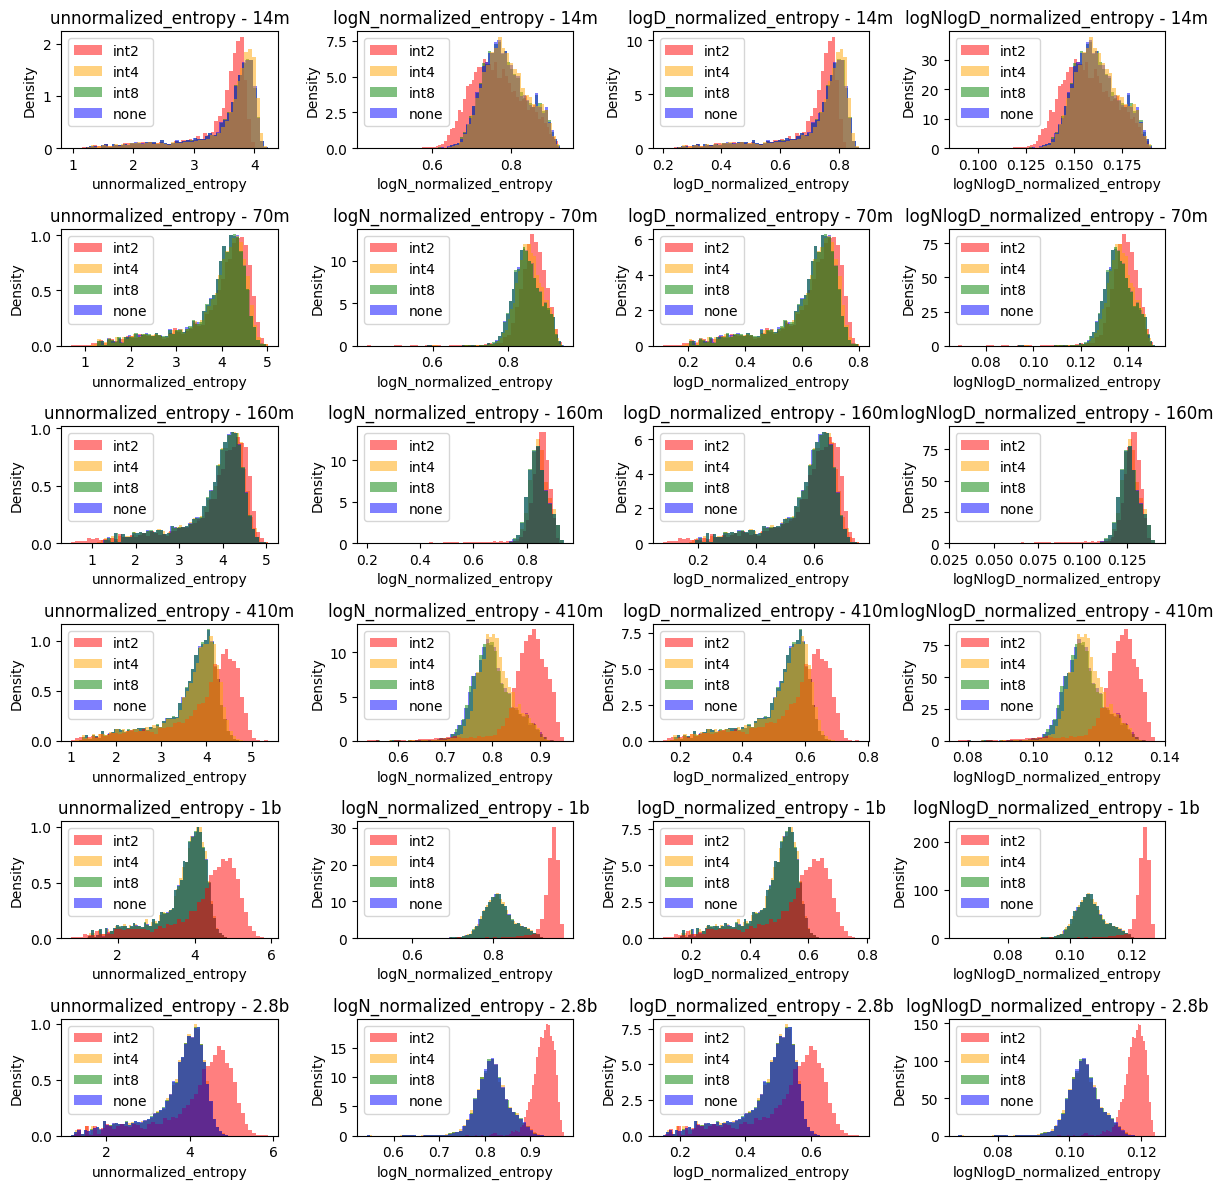

In [137]:
from plots import plot_all_entropies

plot_all_entropies(entropies=entropies, model_sizes=model_sizes, framework="quanto", allow_2bit=True)


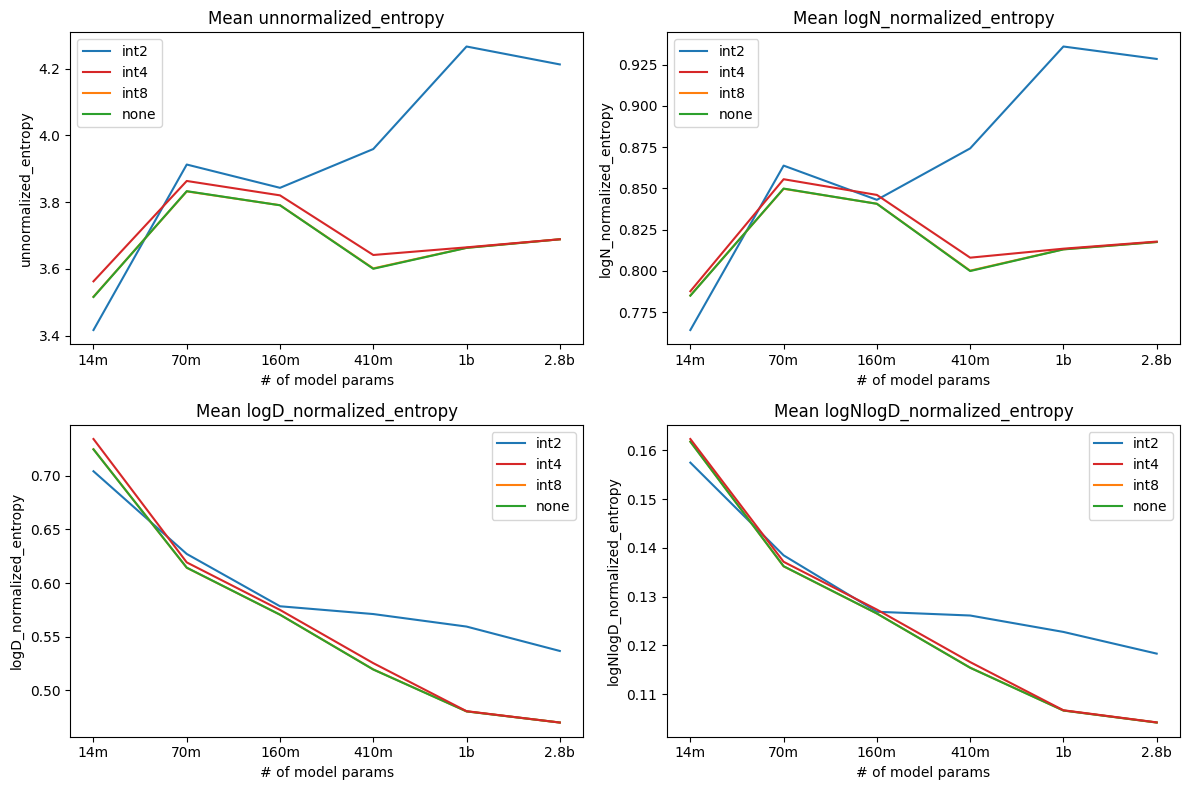

In [179]:
from plots import plot_mean_entropies

plot_mean_entropies(entropies, model_sizes, allow_2bit=True)

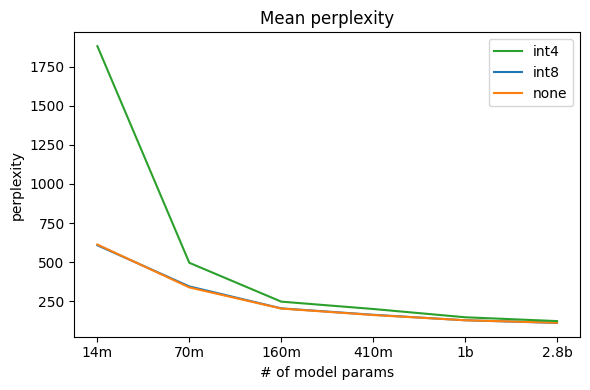

In [180]:
from plots import plot_mean_perplexity

plot_mean_perplexity(entropies, model_sizes)

In [181]:
# import json
# import os

# lm_eval_dir = "../data/lm_eval/"
# eval_results = {}

# for eval_file in os.scandir(lm_eval_dir):
#     if  eval_file.name.startswith('.'):
#         continue
#     with open(eval_file, "r") as f:
#         _results = json.load(f)
#         eval_results[eval_file.name[:-5]] = _results["results"]["hellaswag"]["acc,none"]

In [182]:
# import matplotlib.pyplot as plt

# from collections import defaultdict

# model_sizes = ["14m", "70m", "160m", "410m", "1b"]
# accs = defaultdict(list)

# for i, _size in enumerate(model_sizes):
#     _results = {k: eval_results[k] for k in eval_results.keys() if _size in k}
#     for _model, _acc in _results.items():
#         # compression can be ['none', '8bit', '4bit']
#         _compression = _model.split("-")[-1]
#         accs[_compression].append(_acc)

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# for _compression, _acc in accs.items():
#     ax.plot(model_sizes, _acc, label=_compression)
#     ax.set_title("Accuracy on hellaswag task")
#     ax.set_xlabel("Model size")
#     ax.set_ylabel("Accuracy")
#     ax.legend()